 make some mock square gauge images from rectangular gauge block images
 should be able to do this with a
 rotate to square gauge to image edge
 a scale along width
 reverse the rotation


In [1]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ls_fringeapp import fringeprocess as fp
from ls_fringeapp.load_equipment_data import repo_folder

Equipment Register loaded from /home/elfnor/gits/Length_Stds_Equipment_Register/register.xml
{'red': 632.991212579, 'green': 532.245576449053}


In [3]:
from plot_helpers import draw_gauge

ModuleNotFoundError: No module named 'plot_helpers'

In [223]:
out_image_folder = repo_folder / "tests" / "data" / "mock_square_gauges"
to_process = repo_folder / "tests" / "data" / "Platen03" / "cropped" / "fflog.txt"

In [224]:
d2 = np.genfromtxt(
    to_process,
    delimiter="\t",
    dtype=None,
    usecols=(0, 1, 2, 3, 4, 5, 6, 7),
    unpack=True,
)
ffracs = np.array(d2[0])
fns = d2[1]
xys = np.array(d2[2:8]).T

ffracs[0], fns[0], xys[0]


(np.float64(0.256637),
 np.str_('MSL-03_01-G.bmp'),
 array([   7.8047,  109.37  , 1023.7   ,  178.58  ,  996.06  ,  413.88  ]))

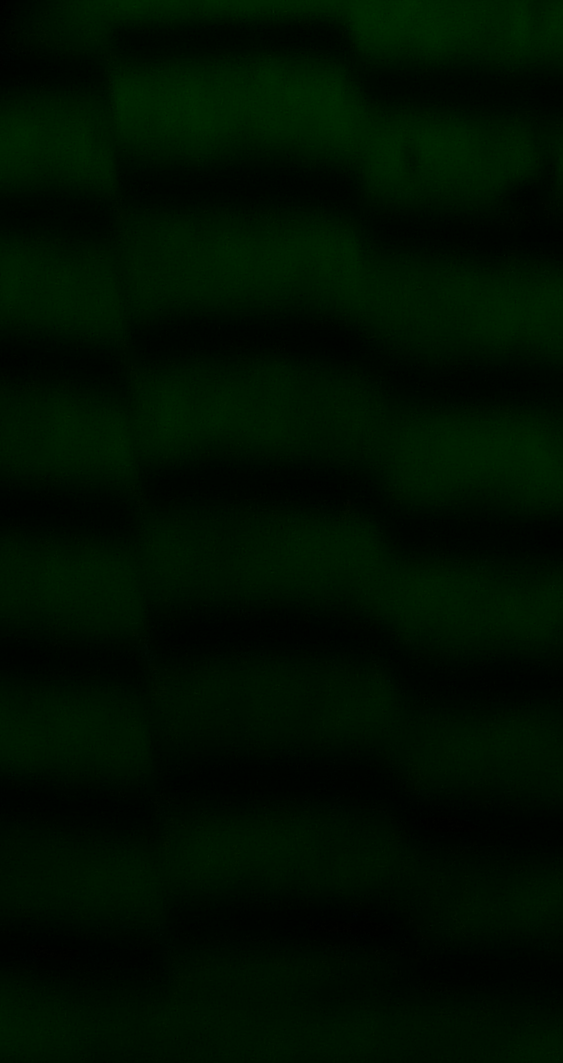

In [225]:
index = 0
img_filename = to_process.parent / fns[index]
img = Image.open(img_filename)
img

In [226]:
type(img)

PIL.BmpImagePlugin.BmpImageFile

In [227]:
f"{img.size=}"

'img.size=(563, 1063)'

In [228]:
xygb = xys[index].reshape((3, 2))
xygb

array([[   7.8047,  109.37  ],
       [1023.7   ,  178.58  ],
       [ 996.06  ,  413.88  ]])

In [229]:
img = img.convert("L", matrix=(1 / 3.0, 1 / 3.0, 1 / 3.0, 0.0))
img_array = np.asarray(img)
img_array.shape

(1063, 563)

In [230]:
ffrac, drawdata = fp.array2frac(img_array, xygb, drawinfo=True)
ffrac, ffracs[index]

(np.float64(0.2554363953191499), np.float64(0.256637))

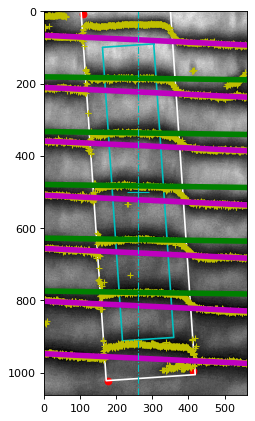

In [231]:
fig = plt.figure(figsize=(6, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array, drawdata)

In [232]:
xy = xygb
length = ((xy[0, :] - xy[1, :]) ** 2).sum() ** 0.5
width = ((xy[1, :] - xy[2, :]) ** 2).sum() ** 0.5
scale = length / width
# angle of left hand edge to x-axis
phi = np.arctan2((xy[0, 1] - xy[1, 1]), (xy[0, 0] - xy[1, 0]))
length, width, np.rad2deg(phi)

(np.float64(1018.250109090144),
 np.float64(236.91783301389532),
 np.float64(-176.10262692198165))

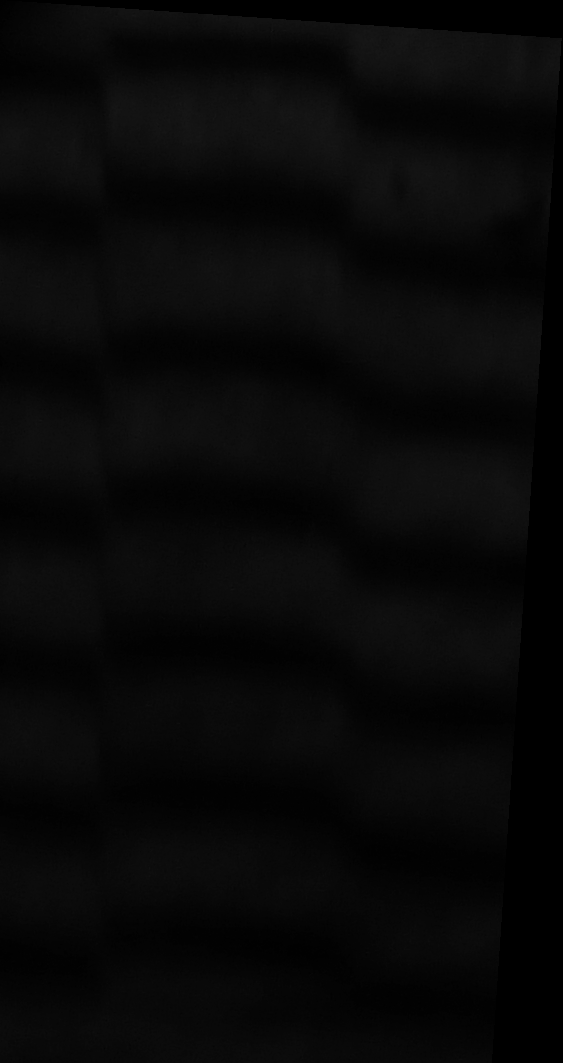

In [ ]:
# rotate gauge square to axis
img1 = img.rotate(-180 - np.rad2deg(phi), center=(0, 0))
img1

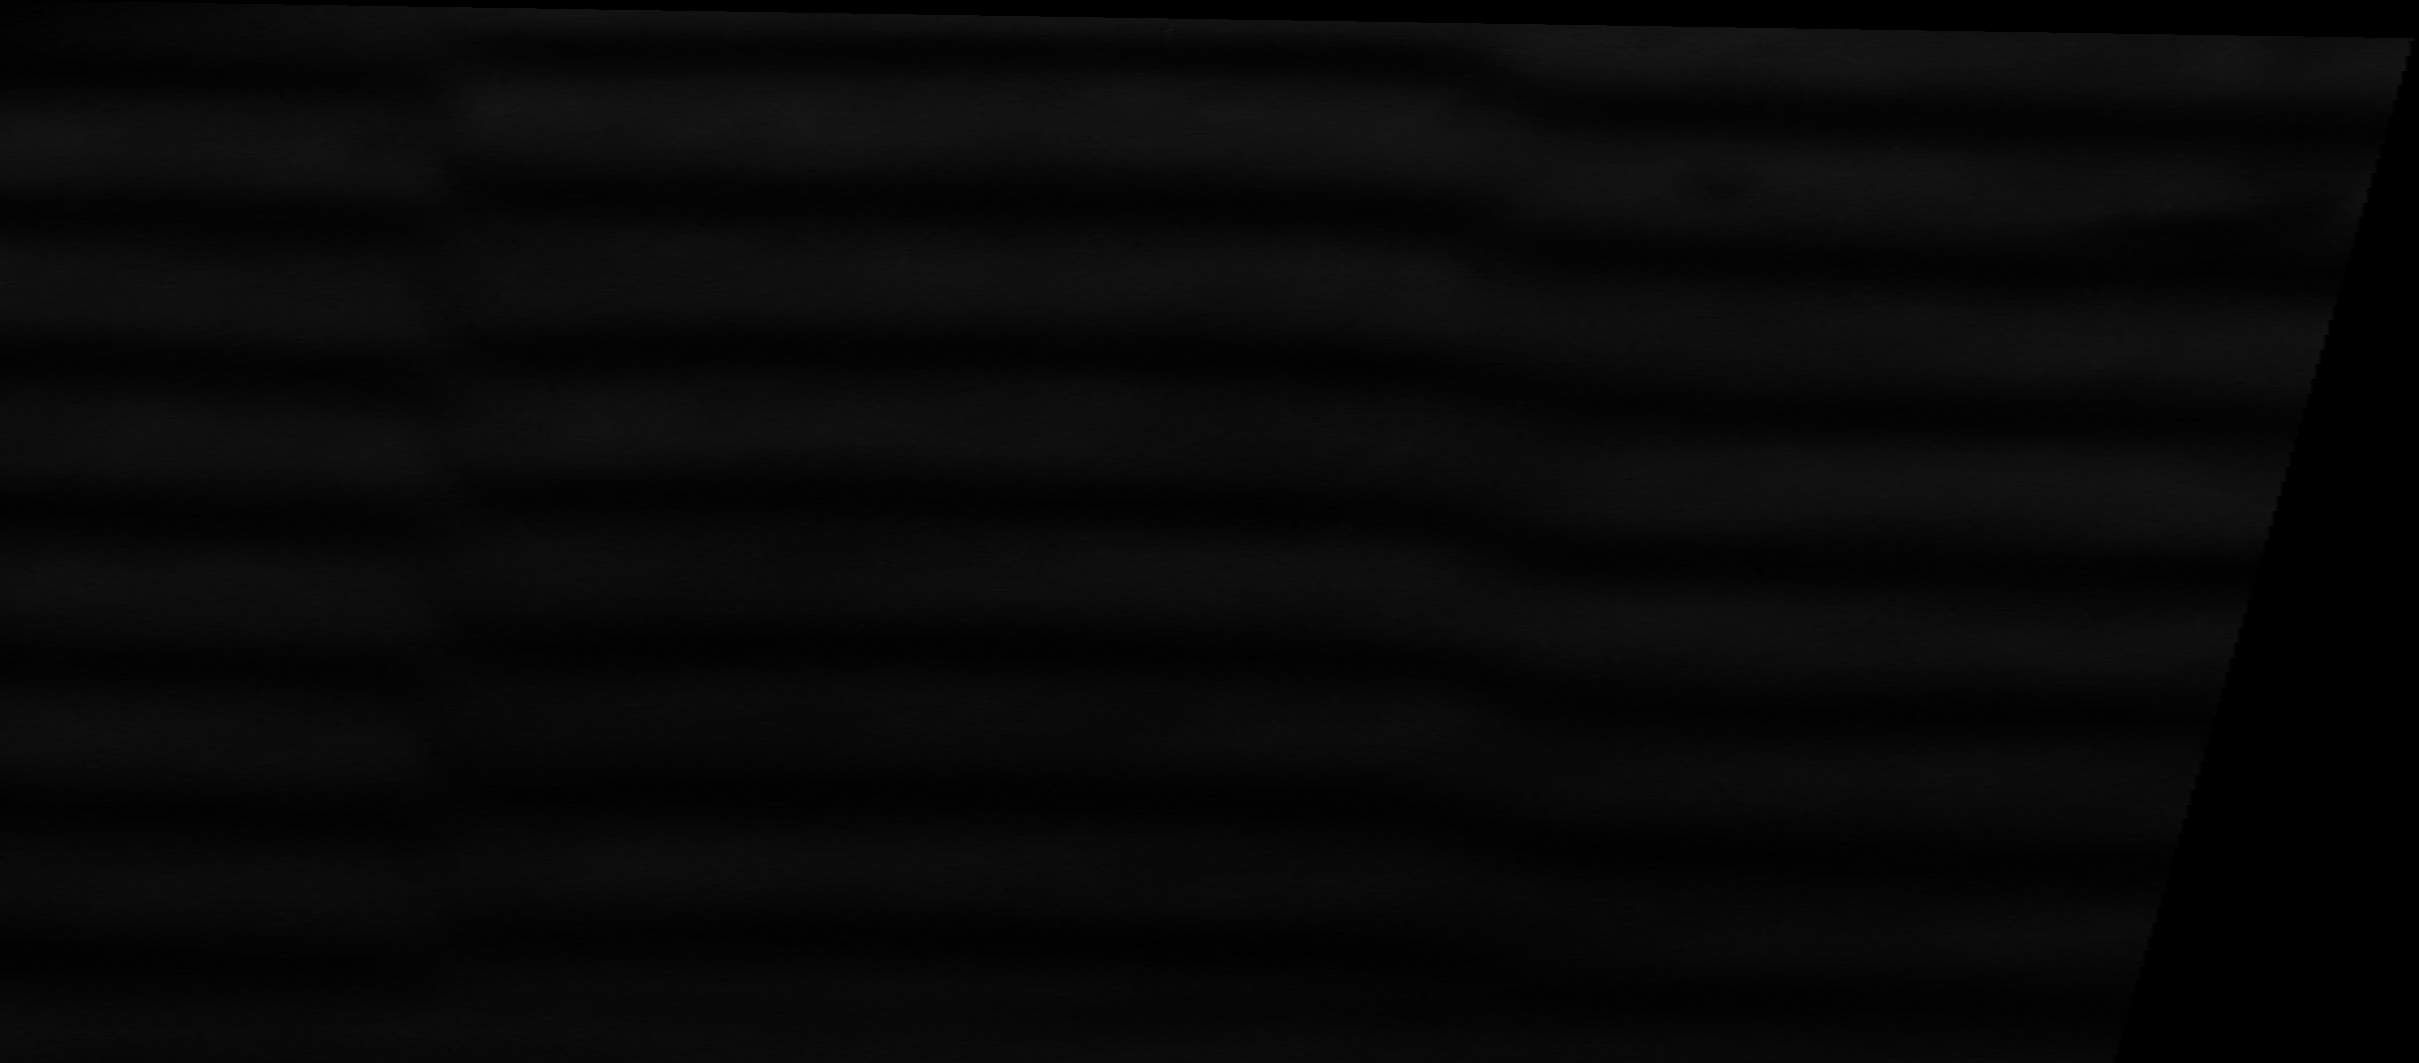

In [234]:
# scale along y
size = (int(scale * img1.size[0]), img1.size[1])
img2 = img1.resize(size)
img2

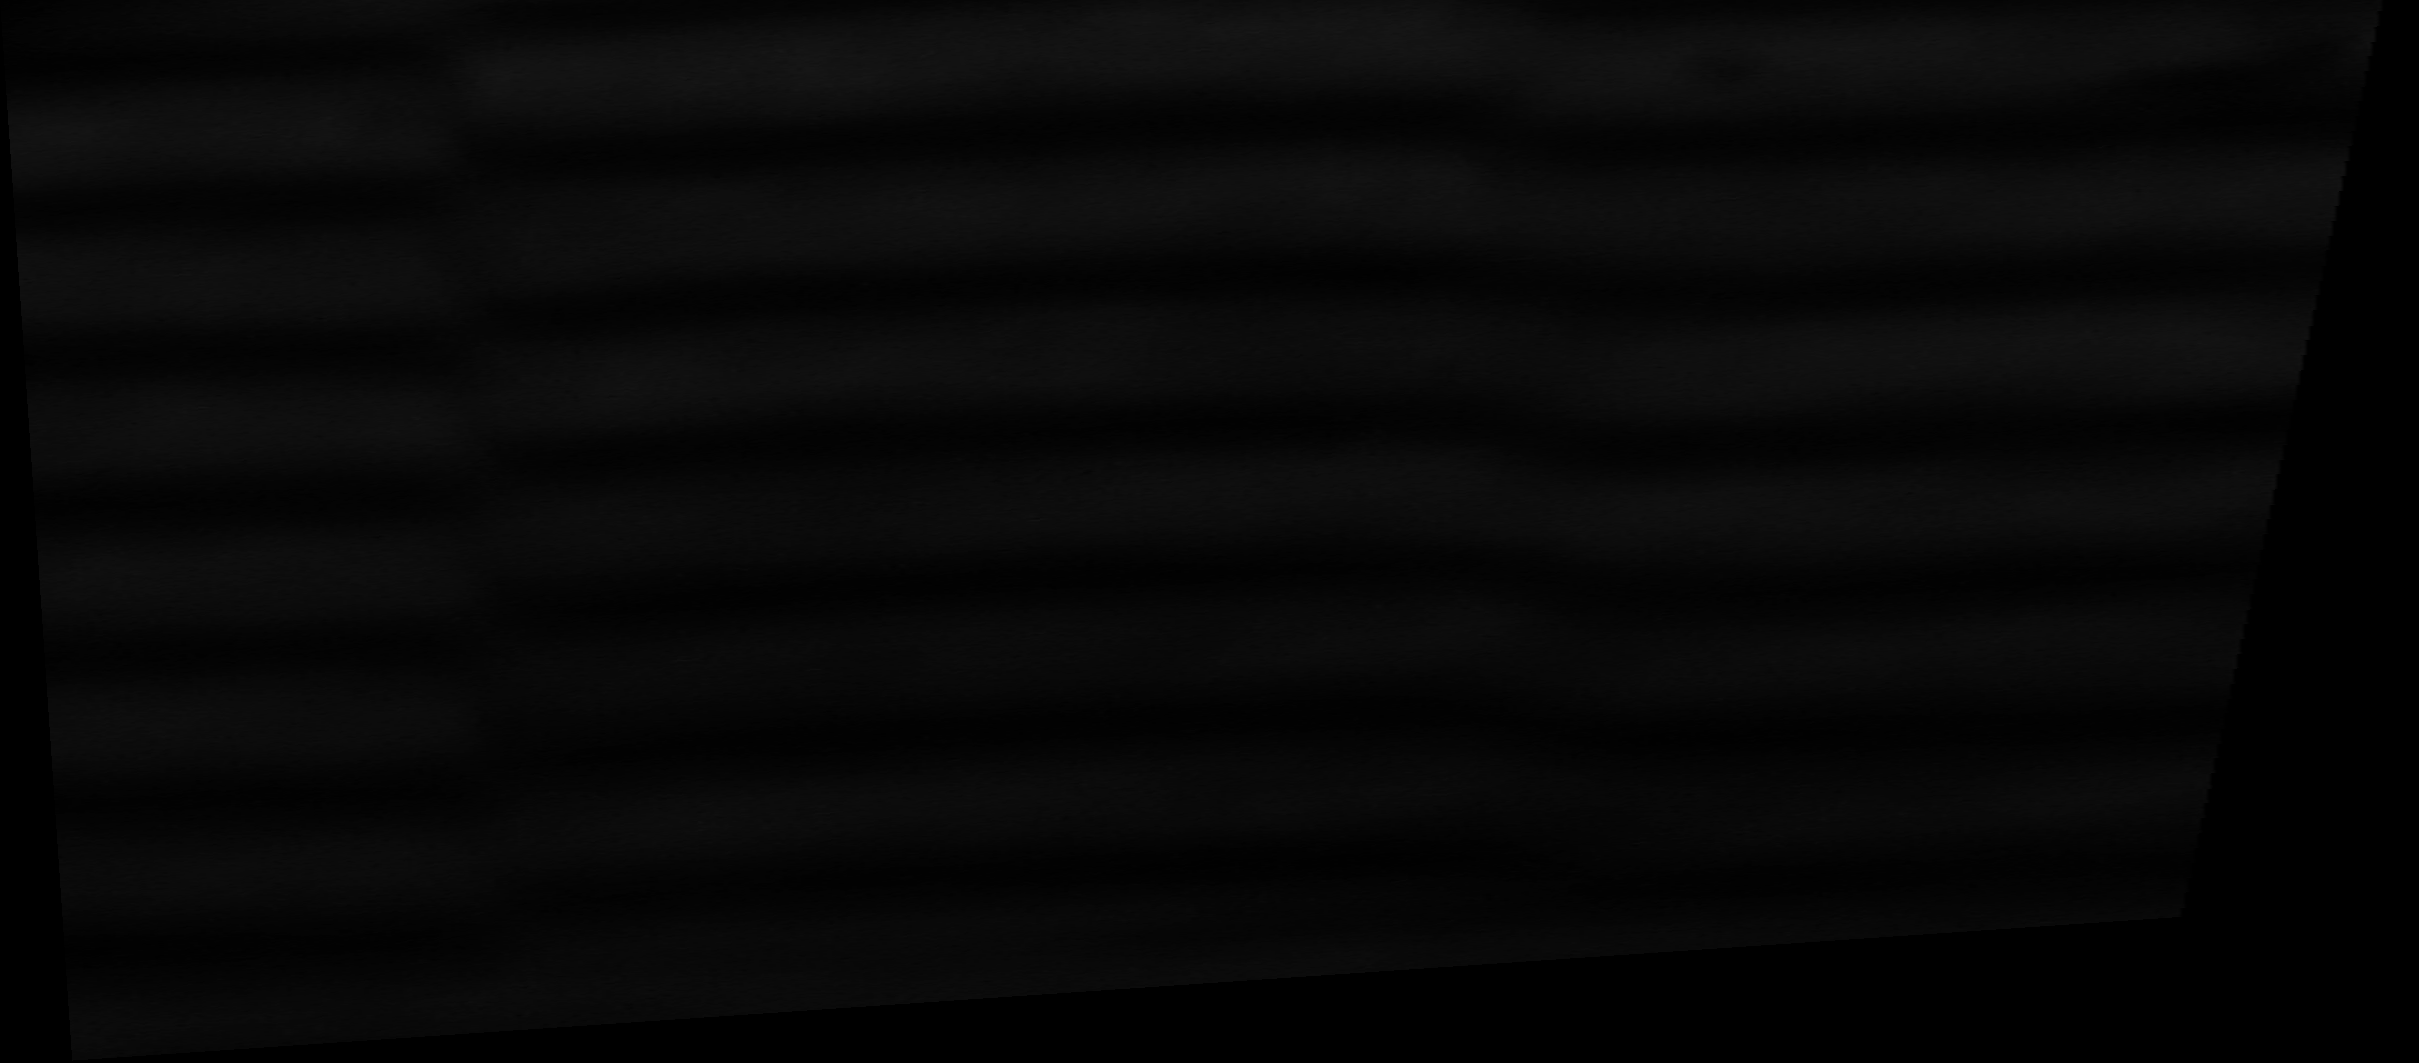

In [ ]:
# rotate back
img3 = img2.rotate(180 + np.rad2deg(phi), center=(0, 0))
img3

In [236]:
img3_array = np.asarray(img3)

(np.float64(-0.5), np.float64(2418.5), np.float64(1062.5), np.float64(-0.5))

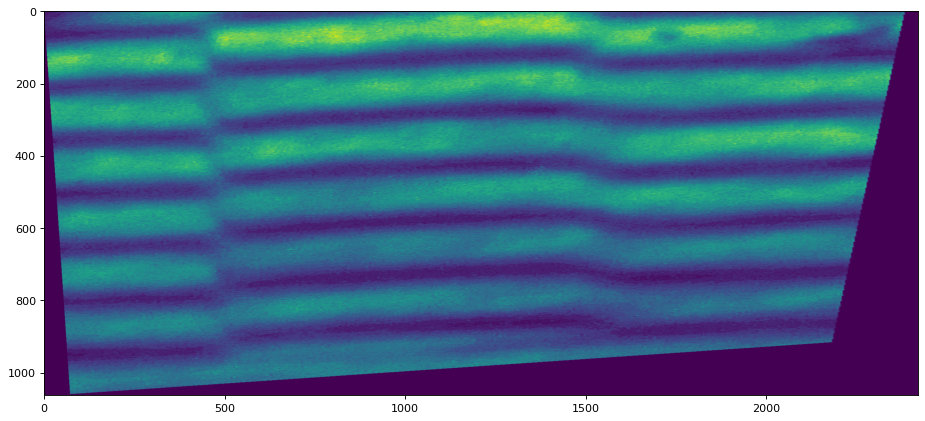

In [237]:
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img3_array)
axes.axis("image")

optical illusion aside this is close enough to square
now need to get xy gauge corners transformed as well

In [238]:
xygb

array([[   7.8047,  109.37  ],
       [1023.7   ,  178.58  ],
       [ 996.06  ,  413.88  ]])

In [ ]:
c, s = np.cos(np.pi - phi), np.sin(np.pi - phi)
R1 = np.array(((c, -s), (s, c)))
R1

array([[ 0.9976874 ,  0.06796955],
       [-0.06796955,  0.9976874 ]])

In [240]:
xy1 = np.dot(R1, xy.T).T
xy1

array([[  15.22048032,  108.58658859],
       [1033.47058941,  108.58658859],
       [1021.8877445 ,  345.22111122]])

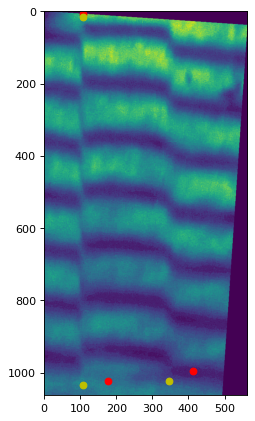

In [241]:
# check
img1_array = np.asarray(img1)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img1_array)
axes.axis("image")
axes.plot(xy[:, 1], xy[:, 0], "or")
axes.plot(xy1[:, 1], xy1[:, 0], "oy")


Which is best centre for rotation, defult is center, I've used orign above, to make calculating gauge corners easier

In [242]:
S = np.array(((1, 0), (0, scale)))
xy2 = np.dot(S, xy1.T).T
xy2

array([[  15.22048032,  466.6947366 ],
       [1033.47058941,  466.6947366 ],
       [1021.8877445 , 1483.72720488]])

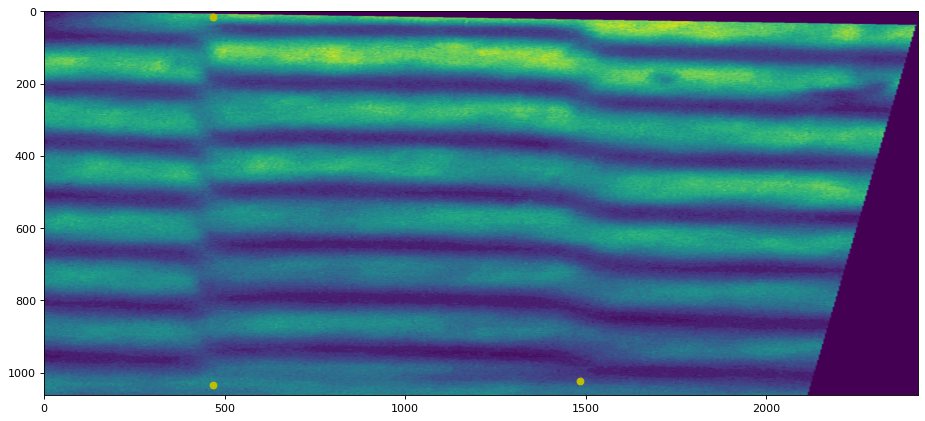

In [243]:
# check
img2_array = np.asarray(img2)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img2_array)
axes.axis("image")
axes.plot(xy2[:, 1], xy2[:, 0], "oy")

In [ ]:
# rotate back
c, s = np.cos(-np.pi + phi), np.sin(-np.pi + phi)
R2 = np.array(((c, -s), (s, c)))
xy3 = np.dot(R2, xy2.T).T
xy3


array([[ -16.53574907,  466.64998574],
       [ 999.35955093,  535.85998574],
       [ 918.67625505, 1549.75318012]])

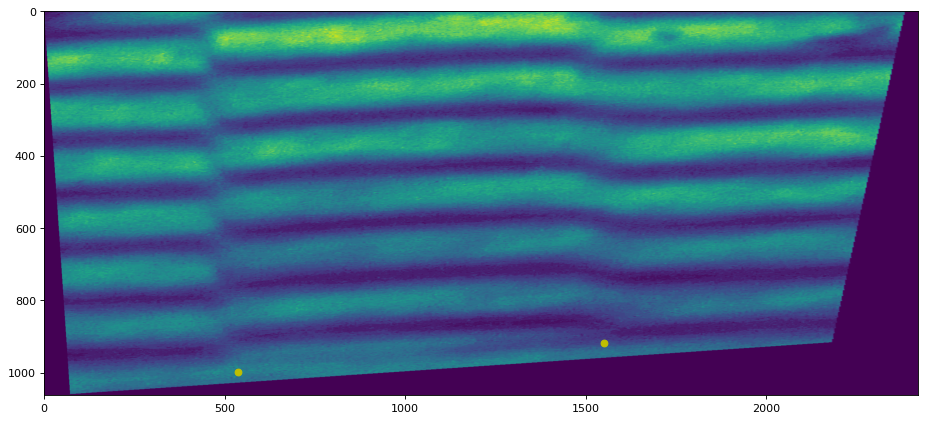

In [245]:
# check
img3_array = np.asarray(img3)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img3_array)
axes.axis("image")
axes.plot(xy3[:, 1], xy3[:, 0], "oy")

top left corner is off image due to rotation about origin, how am I going to crop this for processing?  
other options are rotate about centre , or a gauge corner  

In [246]:
# rotate about centre
img1c = img.rotate(-180 - np.rad2deg(phi))
size = (int(scale * img1c.size[0]), img1c.size[1])
img2c = img1c.resize(size)
img3c = img2c.rotate(180 + np.rad2deg(phi))

(np.float64(-0.5), np.float64(2418.5), np.float64(1062.5), np.float64(-0.5))

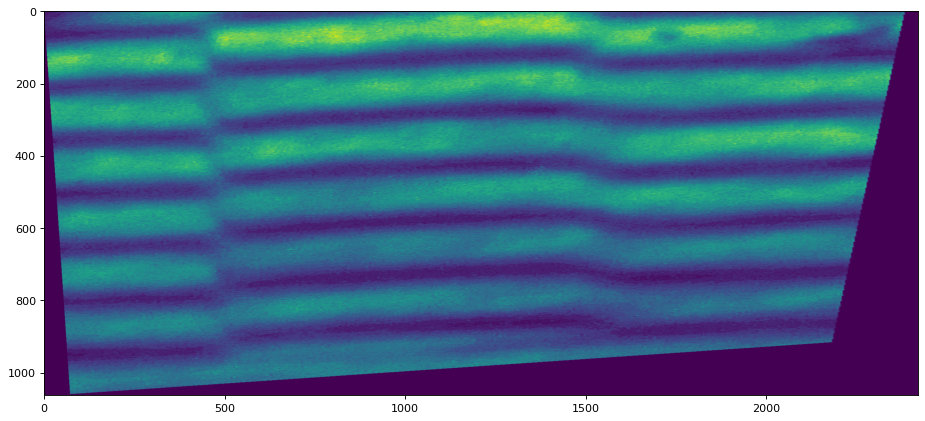

In [247]:
img3c_array = np.asarray(img3c)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img3_array)
axes.axis("image")

I'd say the top right is now out of image, There will be gauges with different angles, that could result in any corner out of image.
There must be a rotation followed by translation that keeps image points within image.
PIL rotate has a expand parameter that "expands the output image to make it large enough to hold the entire rotated image. If false or omitted, make the output image the same size as the input image. Note that the expand flag assumes rotation around the center and no translation."
there is also an optional post rotation translate parameter.

Still have to think about cropping?
I could also go back and recrop raw images 

here's the original with all the fringe image

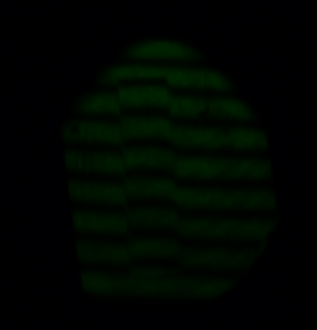

In [248]:
# rotate centre with expand
img1e = img.rotate(-180 - np.rad2deg(phi), expand=True)
size = (int(scale * img1e.size[0]), img1e.size[1])
img2e = img1e.resize(size)
img3e = img2e.rotate(180 + np.rad2deg(phi), expand=True)

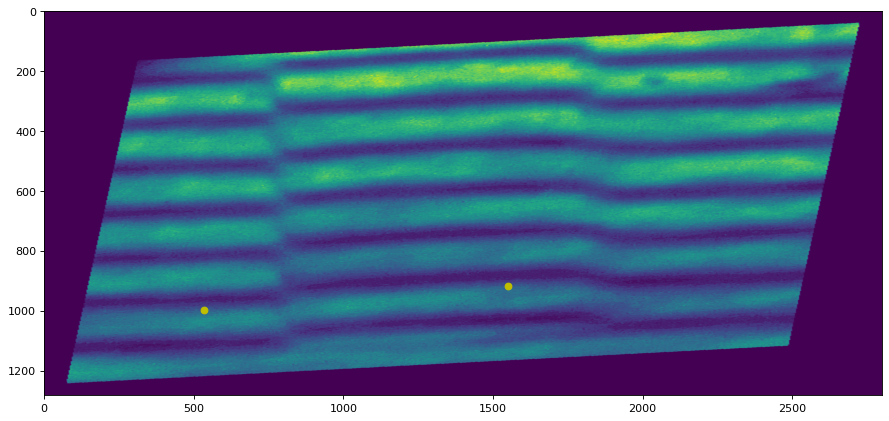

In [249]:
img3e_array = np.asarray(img3e)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img3e_array)
axes.axis("image")
axes.plot(xy3[:, 1], xy3[:, 0], "oy")

How to match the gauge corners to this transformation?  
It must be a simple translation from one to other.  
it must be related to the increase in size of the image.  

In [250]:
img1e = img.rotate(-180 - np.rad2deg(phi), expand=True)
img1e_array = np.asarray(img1e)


In [251]:
trans1 = np.array(img1e.size) - np.array(img.size)
xy1e = xy1 + [trans1[1], trans1[0]]
xy1e

array([[  51.22048032,  180.58658859],
       [1069.47058941,  180.58658859],
       [1057.8877445 ,  417.22111122]])

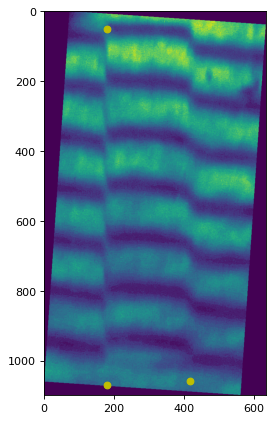

In [252]:
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img1e_array)
axes.axis("image")

axes.plot(xy1e[:, 1], xy1e[:, 0], "oy")


In [253]:
size = (int(scale * img1e.size[0]), img1e.size[1])
img2e = img1e.resize(size)
xy2e = xy1e * [1.0, scale]


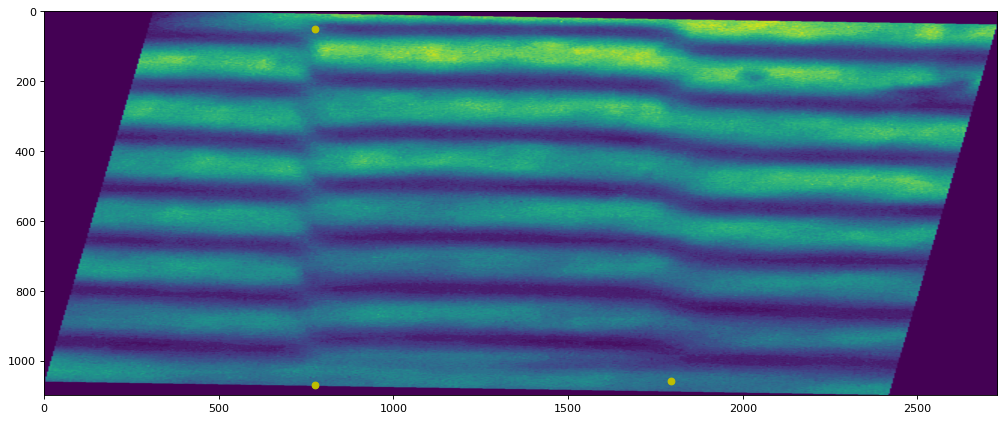

In [254]:
img2e_array = np.asarray(img2e)
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img2e_array)
axes.axis("image")

axes.plot(xy2e[:, 1], xy2e[:, 0], "oy")

In [255]:
img3e = img2e.rotate(180 + np.rad2deg(phi), expand=True)
img3e_array = np.asarray(img3e)


In [256]:
# rotate back
c, s = np.cos(-np.pi + phi), np.sin(-np.pi + phi)
R2 = np.array(((c, -s), (s, c)))
xy3e = np.dot(R2, xy2e.T).T


trans2 = np.array(img3e.size) - np.array(img2e.size)

xy3et = xy3e + [trans2[1], trans2[0]]
xy3et

array([[ 182.3478823 ,  847.83034643],
       [1198.2431823 ,  917.04034643],
       [1117.55988642, 1930.93354081]])

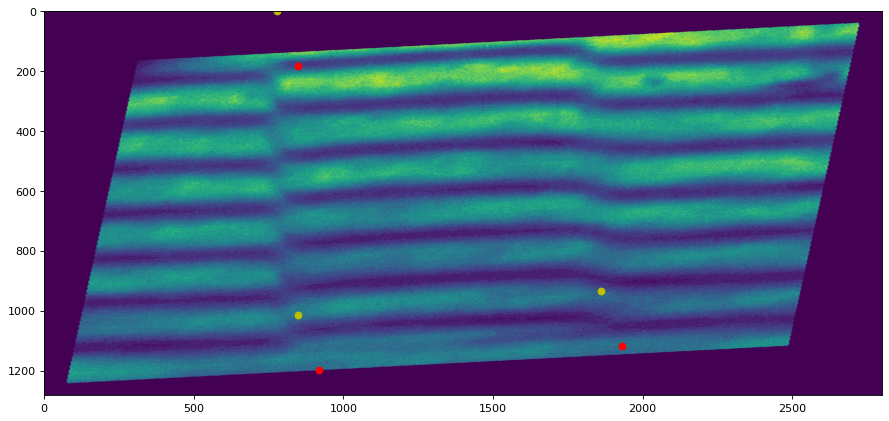

In [259]:
fig = plt.figure(figsize=(20, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.imshow(img3e_array)
axes.axis("image")

axes.plot(xy3e[:, 1], xy3e[:, 0], "oy")
axes.plot(xy3et[:, 1], xy3et[:, 0], "or")

???? yellow is before translation red is after

Take some steps back.  
What am I trying to do?
- produce some images suitable for testing the code for square gauges with central holes
- I need to know what the fringe fractions are for these images.

I've almost got there with both the single affine transform and the seprate rotate sacle undo rotation transforms.  

I'm having the most trouble with also transforming the Gauge corners.  A lot of this is to do with the different CSY's of image and plots.

I'm surprised the final rotation and translation of the corners does not match the image.


There is a `Transform.QUAD` option in PIL
An 8-tuple (x0, y0, x1, y1, x2, y2, x3, y3) which contain the upper left, lower left, lower right, and upper right corner of the source quadrilateral, moving anticlockwise.



# does it with perspective transform
https://stackoverflow.com/a/65990763

as does here

https://pc-pillow.readthedocs.io/en/latest/Image_class/Image_transform.html#transform-perspective

this isn't useful as I don't know how to do the same transform on the gauge corners.

In [ ]:
def find_coeffs(src, dst):
    matrix = []
    for (x, y), (X, Y) in zip(src, dst):
        matrix.extend(
            [
                [x, y, 1, 0, 0, 0, -X * x, -X * y],
                [0, 0, 0, x, y, 1, -Y * x, -Y * y],
            ]
        )
    A = np.matrix(matrix, dtype=float)
    B = np.array(dst).reshape(8)
    res = np.linalg.solve(A, B)
    return np.round(np.array(res).reshape(8), decimals=4)

In [ ]:
coeffs = find_coeffs(
    [(0, 0), (93, 256), (256 + 93, 256), (256, 0)],
    [(0, 0), (0, 256), (256, 256), (256, 0)],
)

In [ ]:
im.